<a href="https://www.kaggle.com/code/darvack/transformer-paper-classification?scriptVersionId=131262531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/transformer/DatasetB.csv
/kaggle/input/transformer/DatasetA.csv


Here, we have loaded the data and set Furan as the label.
At first, we have used 25 percent of the dataset A as the test set to come up with a good model, and then use this model to test in the dataset B.

In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv")
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv")

# Splitting train and test
from sklearn.model_selection import train_test_split
train_set_A, test_set_A = train_test_split(ds_A, test_size = 0.2, random_state = 11)

# Setting the labels
y_train_A = train_set_A['Furan']
y_test_A = test_set_A['Furan']

# Dropping the Furan and Health Index columns
X_train_A = train_set_A.drop(["Furan", "HI"], axis = 1)
X_test_A = test_set_A.drop(["Furan", "HI"], axis = 1)

# For DatasetB
y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis = 1)

# The code below is for the second case, where we train the data for the whole
# Dataset A and test it on Dataset B
y_A = ds_A['Furan']
X_A = ds_A.drop(["Furan", "HI"], axis = 1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[<AxesSubplot: title={'center': 'H2'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'CO2'}>,
        <AxesSubplot: title={'center': 'Methane'}>],
       [<AxesSubplot: title={'center': 'Acetylene'}>,
        <AxesSubplot: title={'center': 'Ethylene'}>,
        <AxesSubplot: title={'center': 'Ethane'}>,
        <AxesSubplot: title={'center': 'Furan'}>],
       [<AxesSubplot: title={'center': 'Water'}>,
        <AxesSubplot: title={'center': 'Acid'}>,
        <AxesSubplot: title={'center': 'BDV'}>,
        <AxesSubplot: title={'center': 'DDF1'}>],
       [<AxesSubplot: title={'center': 'DDF2'}>,
        <AxesSubplot: title={'center': 'Color'}>,
        <AxesSubplot: title={'center': 'IFT'}>,
        <AxesSubplot: title={'center': 'HI'}>]], dtype=object)

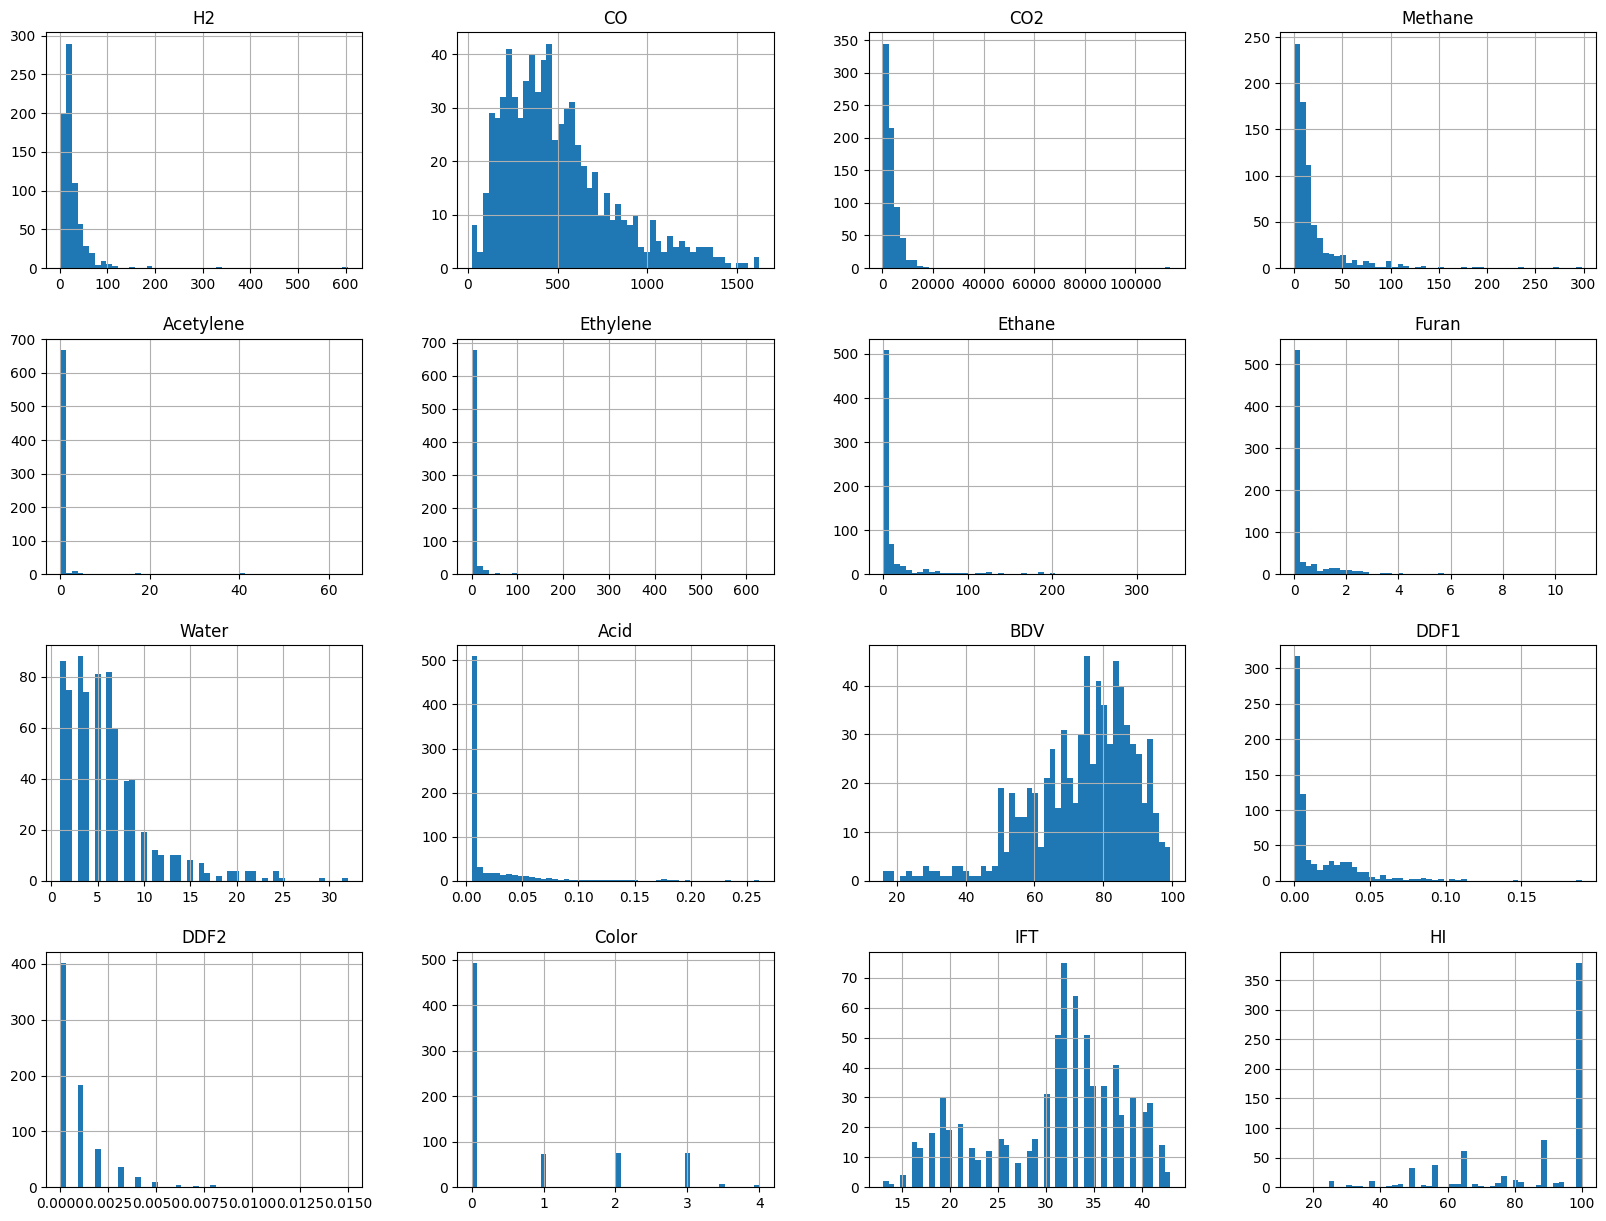

In [3]:
ds_A.hist(bins=50, figsize=(20,15))

The code below, drops the columns that we don't need, and only keeps the common features between dataset A and B.

In [4]:
X_train_A = X_train_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_test_A = X_test_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_train_A.columns]
X_train_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
503,19.0,11.90,0.0,2.7,3.0,5,0.005,73.0,30
679,13.2,9.20,0.0,0.6,2.0,4,0.005,88.0,41
240,14.4,2.50,0.0,0.9,1.5,4,0.005,79.0,31
21,13.2,1.10,0.0,1.8,2.1,4,0.024,78.0,25
56,20.9,0.00,0.6,4.2,3.8,6,0.056,76.0,18
...,...,...,...,...,...,...,...,...,...
269,13.7,5.10,0.0,0.4,1.1,1,0.005,94.0,36
337,32.9,3.77,0.0,0.6,2.4,6,0.005,79.0,32
91,22.8,3.30,0.0,4.9,3.0,11,0.140,88.0,16
80,61.2,27.30,0.0,25.6,20.8,9,0.099,70.0,17


The code below, discretizes the Furan data into 3 classes.

In [5]:
# define the bin edges for each class
bins = [-1, 0.1, 1, 100]

# define the labels for each class
labels = [0, 1, 2]

y_train_A = pd.DataFrame(y_train_A)
y_B = pd.DataFrame(y_B)
y_test_A = pd.DataFrame(y_test_A)
y_A = pd.DataFrame(y_A)

# discretize the data into 3 classes
y_train_A['Class'] = pd.cut(y_train_A['Furan'], bins=bins, labels=labels)
y_B['Class'] = pd.cut(y_B['Furan'], bins=bins, labels=labels)
y_test_A['Class'] = pd.cut(y_test_A['Furan'], bins=bins, labels=labels)
y_A['Class'] = pd.cut(y_A['Furan'], bins=bins, labels=labels)

y_train_A = np.array(y_train_A.drop("Furan", axis = 1)).ravel()
y_B = np.array(y_B.drop("Furan", axis = 1)).ravel()
y_test_A = np.array(y_test_A.drop("Furan", axis = 1)).ravel()
y_A = np.array(y_A.drop("Furan", axis = 1)).ravel()

The below code is a function to plot the confusion matrix

In [6]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 5
)

boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100
)

boruta.fit(np.array(X_train_A), np.array(y_train_A))
green_area = X_train_A.columns[boruta.support_].to_list()
blue_area = X_train_A.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
# useful_features = green_area + blue_area

features in the green area: ['H2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
features in the blue area: []


In [8]:
useful_features = ['Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT', 'Methane']

**Removing the outliers**

In [9]:
#Capping the outlier rows with Percentiles
upper_lim = X_train_A['Ethylene'].quantile(.97)
X_train_A.loc[(X_train_A['Ethylene'] > upper_lim),'Ethylene'] = upper_lim

upper_lim = X_train_A['Methane'].quantile(.97)
X_train_A.loc[(X_train_A['Methane'] > upper_lim),'Methane'] = upper_lim

upper_lim = X_train_A['BDV'].quantile(.97)
X_train_A.loc[(X_train_A['BDV'] > upper_lim),'BDV'] = upper_lim

upper_lim = X_train_A['Ethane'].quantile(.97)
X_train_A.loc[(X_train_A['Ethane'] > upper_lim),'Ethane'] = upper_lim

In [10]:
X_train_A.describe()

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,26.585445,17.355596,1.737329,4.243973,18.066298,6.047945,0.020393,74.263527,30.917808
std,25.169207,22.604983,7.283524,6.610086,38.680163,4.756265,0.035506,14.651125,7.161462
min,1.900000,0.000000,0.000000,0.000000,0.000000,1.000000,0.005000,16.000000,13.000000
25%,13.400000,4.375000,0.000000,1.100000,1.800000,3.000000,0.005000,66.000000,26.750000
50%,19.300000,10.000000,0.000000,1.900000,3.200000,5.000000,0.005000,77.000000,32.000000
75%,31.100000,17.825000,0.000000,4.300000,9.300000,8.000000,0.018000,85.000000,36.000000
max,329.300000,98.561000,64.300000,31.910000,168.951000,32.000000,0.261000,95.500000,43.000000


# First case: Training using 80% of the data and testing on the remaining 20%

We have experimented a combination of different models in the ensemble.
Although the results were quite similar, we found that a combination of KNN, svm, mlp and logistic regression works best.
In the code below we have created a voting classifier consist of these models.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

rf_clf = RandomForestClassifier(n_jobs = -1, max_depth = 50)
svm_clf = SVC(probability=True, gamma=0.001)
knn_clf = KNeighborsClassifier(n_neighbors=3)
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)
lr_clf = LogisticRegression(max_iter=10000)

voting_clf = VotingClassifier(
  estimators=[('nn', mlp_clf),
              ('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),('nb', nb_clf)
              #('xgb', xgb_clf),
              ('lr', lr_clf)],
  voting='hard')
voting_clf.fit(X_train_A[useful_features], np.array(y_train_A).ravel())

VotingClassifier(estimators=[('nn', MLPClassifier(max_iter=1000)),
                             ('svc', SVC(gamma=0.001, probability=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('lr', LogisticRegression(max_iter=10000))])

Here is a comparison of different models and the voting classifier.

In [12]:
from sklearn.metrics import accuracy_score
for clf in (mlp_clf, svm_clf, ada_clf,
            knn_clf, xgb_clf, rf_clf, nb_clf,
            lr_clf, voting_clf):
    clf.fit(X_train_A[useful_features], y_train_A)
    y_pred_A = clf.predict(X_test_A[useful_features])
    y_pred_B = clf.predict(X_B[useful_features])
    print(clf.__class__.__name__ + " for dataset A:", accuracy_score(y_test_A, y_pred_A))
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

MLPClassifier for dataset A: 0.8424657534246576
MLPClassifier for dataset B: 0.8318042813455657
SVC for dataset A: 0.8698630136986302
SVC for dataset B: 0.8409785932721713
AdaBoostClassifier for dataset A: 0.8013698630136986
AdaBoostClassifier for dataset B: 0.7767584097859327
KNeighborsClassifier for dataset A: 0.863013698630137
KNeighborsClassifier for dataset B: 0.8409785932721713
XGBClassifier for dataset A: 0.8835616438356164
XGBClassifier for dataset B: 0.7553516819571865
RandomForestClassifier for dataset A: 0.8698630136986302
RandomForestClassifier for dataset B: 0.7217125382262997
GaussianNB for dataset A: 0.8698630136986302
GaussianNB for dataset B: 0.7308868501529052
LogisticRegression for dataset A: 0.8561643835616438
LogisticRegression for dataset B: 0.8042813455657493
VotingClassifier for dataset A: 0.9041095890410958
VotingClassifier for dataset B: 0.8532110091743119


Confusion matrix, without normalization
[[103   0   1]
 [  4  11   8]
 [  2   1  16]]


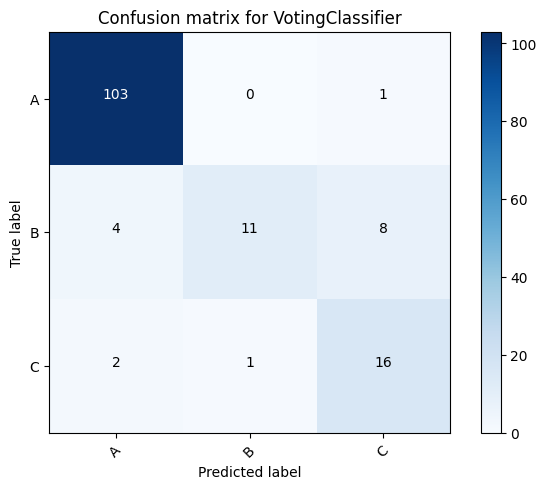

In [13]:
class_names = ['A', 'B', 'C']
voting_clf.fit(X_train_A[useful_features], y_train_A)
y_pred_A = voting_clf.predict(X_test_A[useful_features])
cnf_matrix = confusion_matrix(y_test_A, y_pred_A)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + voting_clf.__class__.__name__)
plt.show()

Confusion matrix, without normalization
[[102   1   1]
 [  5  11   7]
 [  3   3  13]]


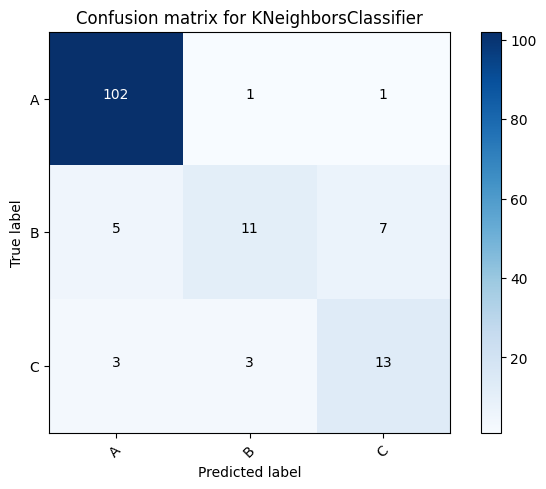

In [14]:
class_names = ['A', 'B', 'C']
knn_clf.fit(X_train_A[useful_features], y_train_A)
y_pred_A = knn_clf.predict(X_test_A[useful_features])
cnf_matrix = confusion_matrix(y_test_A, y_pred_A)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + knn_clf.__class__.__name__)
plt.show()

# Second case: Training using all of the data from Dataset A

So far we have used 80% of Dataset A to train the data and 20% to test it.
Here, we used all of the data from Dataset A to train, and then test it on Dataset B.

In [15]:
#Capping the outlier rows with Percentiles
upper_lim = X_A['Ethylene'].quantile(.97)
X_A.loc[(X_A['Ethylene'] > upper_lim),'Ethylene'] = upper_lim

upper_lim = X_A['Methane'].quantile(.97)
X_A.loc[(X_A['Methane'] > upper_lim),'Methane'] = upper_lim

upper_lim = X_A['BDV'].quantile(.97)
X_A.loc[(X_A['BDV'] > upper_lim),'BDV'] = upper_lim

upper_lim = X_A['Ethane'].quantile(.97)
X_A.loc[(X_A['Ethane'] > upper_lim),'Ethane'] = upper_lim

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

lr_clf = LogisticRegression(max_iter=10000)
svm_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)

voting_clf = VotingClassifier(
  estimators=[('nn', mlp_clf),
              ('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),('nb', nb_clf)
              ('lr', lr_clf),#('xgb', xgb_clf)
             ],
  voting='hard')
voting_clf.fit(X_A[useful_features], y_A)

VotingClassifier(estimators=[('nn', MLPClassifier(max_iter=1000)),
                             ('svc', SVC(probability=True)),
                             ('knn', KNeighborsClassifier()),
                             ('lr', LogisticRegression(max_iter=10000))])

In [17]:
from sklearn.metrics import accuracy_score

for clf in (mlp_clf, svm_clf, ada_clf,
            knn_clf, xgb_clf, lr_clf, nb_clf,
            voting_clf):
    clf.fit(X_A[useful_features], y_A)
    y_pred_B = clf.predict(X_B[useful_features])
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

MLPClassifier for dataset B: 0.8532110091743119
SVC for dataset B: 0.8287461773700305
AdaBoostClassifier for dataset B: 0.7767584097859327
KNeighborsClassifier for dataset B: 0.8501529051987767
XGBClassifier for dataset B: 0.7308868501529052
LogisticRegression for dataset B: 0.8165137614678899
GaussianNB for dataset B: 0.7400611620795107
VotingClassifier for dataset B: 0.8318042813455657


Confusion Matrix:

Confusion matrix, without normalization
[[242  10   5]
 [ 14  18   8]
 [  4   8  18]]


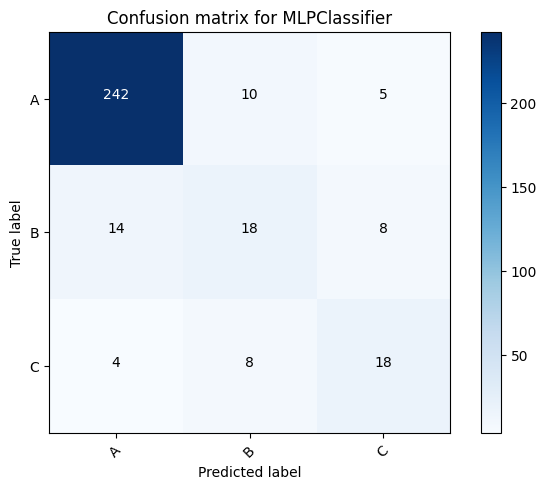

Confusion matrix, without normalization
[[247   4   6]
 [ 13   0  27]
 [  6   0  24]]


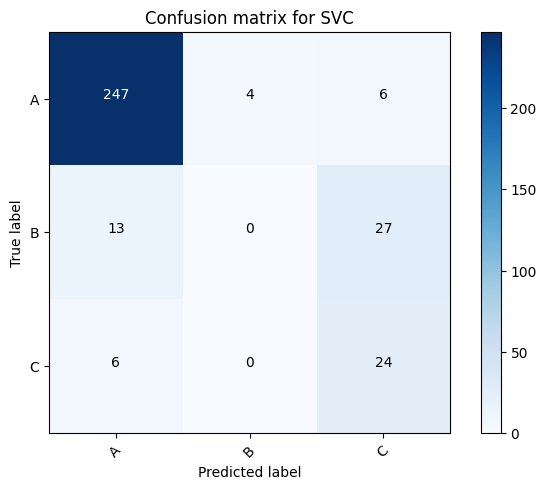

Confusion matrix, without normalization
[[243   7   7]
 [  9  19  12]
 [  6   8  16]]


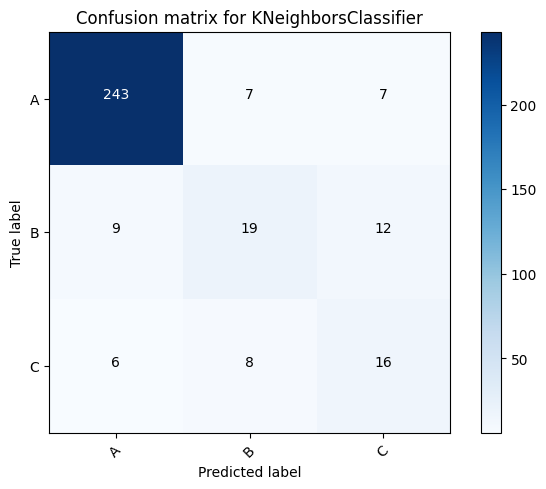

Confusion matrix, without normalization
[[209  32  16]
 [  6   4  30]
 [  3   1  26]]


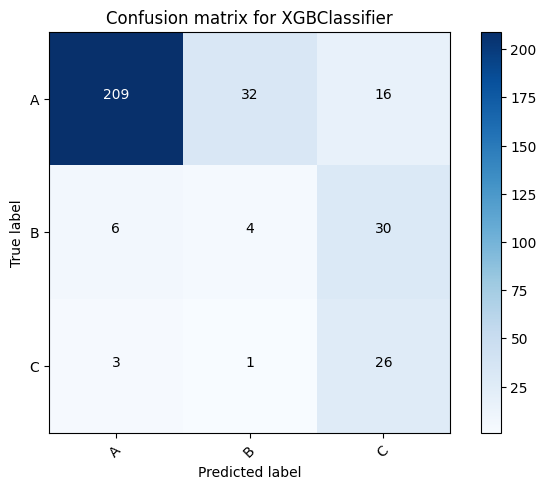

Confusion matrix, without normalization
[[239  10   8]
 [ 10   4  26]
 [  6   0  24]]


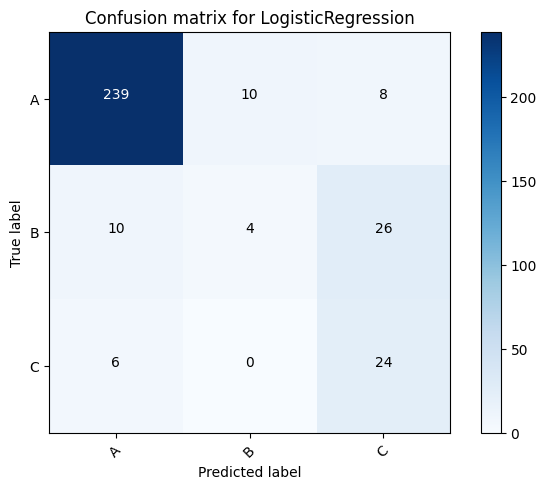

Confusion matrix, without normalization
[[247   6   4]
 [ 12  12  16]
 [  7   5  18]]


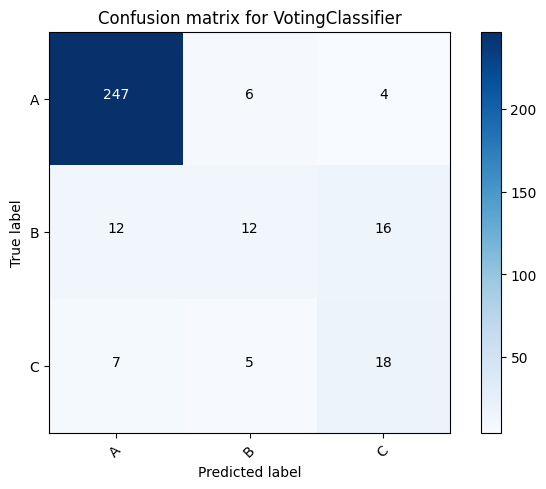

In [18]:
class_names = ['A', 'B', 'C']

for clf in (mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, lr_clf, #nb_clf,
            voting_clf):
    clf.fit(X_A[useful_features], y_A)
    y_pred_B = clf.predict(X_B[useful_features])
    cnf_matrix = confusion_matrix(y_B, y_pred_B)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix for ' + clf.__class__.__name__)
    plt.show()

Confusion matrix, without normalization
[[247   6   4]
 [ 14  12  14]
 [  6   3  21]]


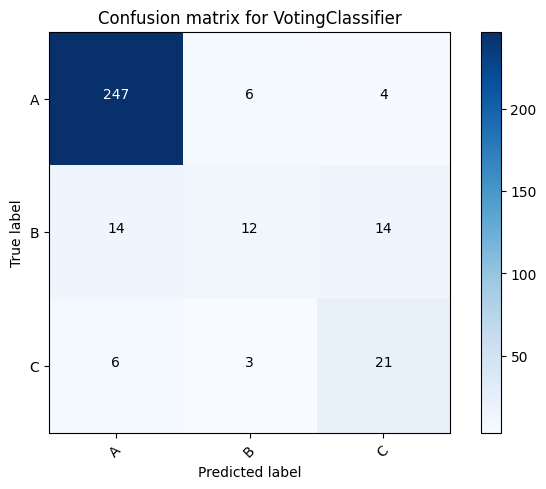

In [19]:
class_names = ['A', 'B', 'C']
voting_clf.fit(X_A[useful_features], y_A)
y_pred_B = voting_clf.predict(X_B[useful_features])
cnf_matrix = confusion_matrix(y_B, y_pred_B)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + voting_clf.__class__.__name__)
plt.show()

Confusion matrix, without normalization
[[243   7   7]
 [  9  19  12]
 [  6   8  16]]


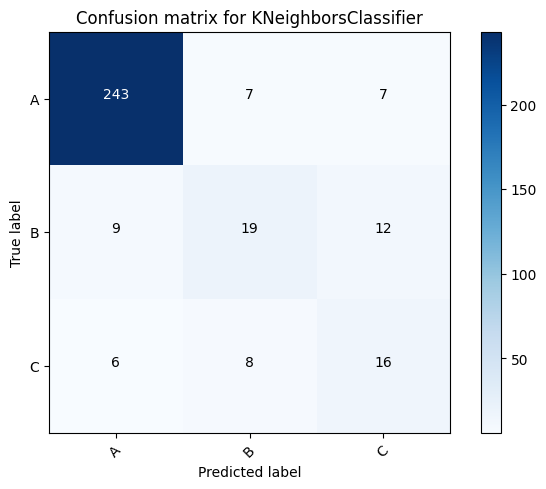

In [20]:
class_names = ['A', 'B', 'C']
knn_clf.fit(X_A[useful_features], y_A)
y_pred_B = knn_clf.predict(X_B[useful_features])
cnf_matrix = confusion_matrix(y_B, y_pred_B)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + knn_clf.__class__.__name__)
plt.show()

**Under Sampling the majority class to deal with the imbalance of the data**

KNeighborsClassifier for dataset A: 0.863013698630137
KNeighborsClassifier for dataset B: 0.8562691131498471
[[101   2   1]
 [  4  15   4]
 [  1   8  10]]

 [[244   7   6]
 [  7  25   8]
 [  5  14  11]]
Confusion matrix, without normalization
[[101   2   1]
 [  4  15   4]
 [  1   8  10]]


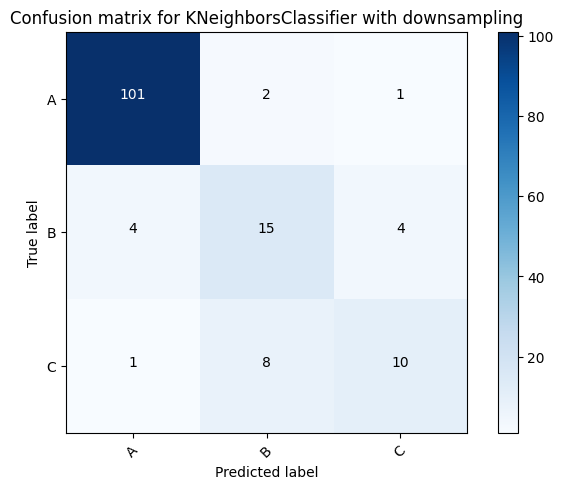

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import accuracy_score

class_names = ['A', 'B', 'C']
# Downsample the first class
rus = OneSidedSelection(sampling_strategy='auto')#,random_state=11)
X_train_A_downsampled, y_train_A_downsampled = rus.fit_resample(X_train_A, y_train_A)

# Fit the model
knn_clf_down = KNeighborsClassifier(n_neighbors=4)
knn_clf_down.fit(X_train_A_downsampled[useful_features], y_train_A_downsampled)

# Predict the labels on the test set
y_pred_A = knn_clf_down.predict(X_test_A[useful_features])
print(knn_clf_down.__class__.__name__ + " for dataset A:", accuracy_score(y_test_A, y_pred_A))
y_pred_B = knn_clf_down.predict(X_B[useful_features])
print(knn_clf_down.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test_A, y_pred_A)


# Print the confusion matrix
np.set_printoptions(precision=2)
print(cnf_matrix)
print("\n",confusion_matrix(y_B, y_pred_B))

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + knn_clf_down.__class__.__name__ + ' with downsampling')
plt.show()

VotingClassifier for dataset A: 0.8835616438356164
VotingClassifier for dataset B: 0.8593272171253823
[[103   0   1]
 [  4  13   6]
 [  2   4  13]]

 [[247   6   4]
 [ 15  14  11]
 [  6   4  20]]
Confusion matrix, without normalization
[[247   6   4]
 [ 15  14  11]
 [  6   4  20]]


Confusion matrix, without normalization
[[103   0   1]
 [  4  13   6]
 [  2   4  13]]


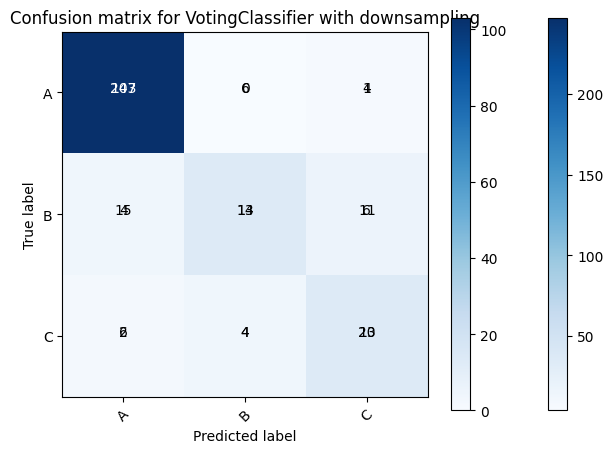

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import accuracy_score

class_names = ['A', 'B', 'C']
# Downsample the first class
rus = OneSidedSelection(sampling_strategy='auto')#,random_state=11)
X_train_A_downsampled, y_train_A_downsampled = rus.fit_resample(X_train_A, y_train_A)

# Fit the model
voting_clf_down = VotingClassifier(
  estimators=[('nn', mlp_clf),
              ('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),('nb', nb_clf)
              ('lr', lr_clf),#('xgb', xgb_clf)
             ],
  voting='hard')
voting_clf_down.fit(X_train_A_downsampled[useful_features], y_train_A_downsampled)

# Predict the labels on the test set
y_pred_A = voting_clf_down.predict(X_test_A[useful_features])
print(voting_clf_down.__class__.__name__ + " for dataset A:", accuracy_score(y_test_A, y_pred_A))
y_pred_B = voting_clf_down.predict(X_B[useful_features])
print(voting_clf_down.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test_A, y_pred_A)


# Print the confusion matrix
np.set_printoptions(precision=2)
print(cnf_matrix)
print("\n",confusion_matrix(y_B, y_pred_B))

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(y_B, y_pred_B), classes=class_names,
                      title='Confusion matrix for ' + voting_clf_down.__class__.__name__ + ' with downsampling')
print("\n")
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + voting_clf_down.__class__.__name__ + ' with downsampling')
plt.show()